In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams["figure.figsize"] = [16, 10] 

In [2]:
def parse_trace(di, fix = 0):
    trace = pd.DataFrame(columns=["event", "id", "ts", "location"])
    for dirpath, dnames, fnames in os.walk(di):
        for f in fnames:
            if f.endswith(".csv"):
                t = pd.read_csv(os.path.join(dirpath, f), header=None, names=['event', 'id', 'ts'])
                t['location'] =  os.path.splitext(f)[0]
                trace = pd.concat([trace, t])
    trace = trace.set_index("id")
    return trace.apply(pd.to_numeric, errors='ignore')

In [3]:
def delay_between(trace, from_event, to_event, from_location = None, to_location = None):
    data = trace[(trace['event'] == from_event) | (trace['event'] == to_event)]
    joined = trace.join(trace, lsuffix='_from', rsuffix='_to', how='inner')
    filtered = joined[(joined['event_from'] == from_event) & (joined['event_to'] == to_event)]
    if from_location is not None:
        filtered = filtered[filtered['location_from'] == from_location]
    if to_location is not None:
        filtered = filtered[filtered['location_to'] == to_location]
    result = np.array((filtered['ts_to'] - filtered['ts_from']).unique(), dtype=np.int64)
    if len(result) < 500:
        print("There are " + str(len(result)) + " events from: '" + from_event + "', to: '" + to_event + ";")
    return result

In [4]:
def sync_skew(trace, from_event, to_event):
    for location in trace['location'].unique():
        d = delay_between(trace, from_event, to_event, from_location=location)
        if d.size > 0:
            min = d.min()
            trace.loc[trace['location'] == location, 'ts'] += min
    return trace

In [5]:
def read_data(filename):
    with open(filename) as f:
        d = np.array(f.read().strip().split(','), dtype=np.int64)
        return d[1000:] / 1e6

In [6]:
def plot_latency(data, label = None):
    if label is None:
        plt.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0))
    else:
        plt.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0), label = None)

# Tracing

In [7]:
def plot_fs_trace(trace):
    plt.xlim((0, 1))
    plt.ylim((0, 40))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(trace, 'bench-send', 'front-receive-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    to_source = delay_between(trace, 'front-receive-send', 'flatmap-receive') / 1e6
    to_source = to_source[to_source > 1]
    plt.plot(np.linspace(0, 1, np.size(to_source)), np.sort(to_source), "g", label="front - flatmap (shuffle)")
    part = delay_between(trace, 'fm-send', 'inject-in') / 1e6
    plt.plot(np.linspace(0, 1, np.size(part)), np.sort(part), "b", label="flatmap - grouping (shuffle)")

    rear_bench = delay_between(trace, 'rear-in', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(rear_bench)), np.sort(rear_bench), "m", label="rear - bench (network)")

    plt.legend(loc='upper left')

In [8]:
def plot_fl_trace(trace):
    plt.xlim((0, 1))
    plt.ylim((0, 40))
    plt.xlabel("Quantile")
    plt.ylabel("Latency (ms)")

    bench_front = delay_between(flink_trace, 'bench-send', 'source-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(bench_front)), np.sort(bench_front), "r", label="bench - front (network)")

    source_fm = delay_between(flink_trace, 'source-receive', 'flatmap-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(source_fm)), np.sort(source_fm), "g", label="front - flatmap (shuffle)")

    fm_enforcer = delay_between(flink_trace, 'flatmap-send', 'enforcer-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(fm_enforcer)), np.sort(fm_enforcer), "b", label="flatmap - enforcer (shuffle)")

    a = delay_between(flink_trace, 'enforcer-receive', 'enforcer-send') / 1e6
    plt.plot(np.linspace(0, 1, np.size(a)), np.sort(a), "y", label="order enforcer")

    enforcer_sink = delay_between(flink_trace, 'enforcer-send', 'sink-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(enforcer_sink)), np.sort(enforcer_sink), label="enforcer - sink")

    sink_bench = delay_between(flink_trace, 'sink-receive', 'bench-receive') / 1e6
    plt.plot(np.linspace(0, 1, np.size(sink_bench)), np.sort(sink_bench), "m", label="sink - bench (network)")

    plt.legend(loc='upper left')


In [9]:
trace = sync_skew(parse_trace("data/bc21dbaf/10/70/flamestream/traces"), 'rear-in', 'bench-receive')
start = trace['ts'].min() + 200 * (100 * 1e6)
trace = trace[trace['ts'] > start]
trace.shape

There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;
There are 0 events from: 'rear-in', to: 'bench-receive;


(96659, 3)

# End-to-end latencies analysis

In [10]:
fs_w= {}
for workers in [10, 8, 6]:
    fs_w[workers] = read_data('data/bc21dbaf/' + str(workers) + '/70/flamestream/latency/lat.data')

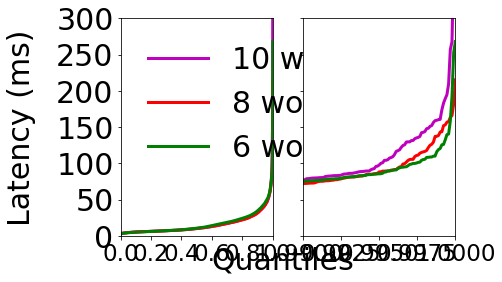

In [11]:
colors = {6 : 'g', 8 : 'r', 10 : 'm'}
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_xlim((.0, 1))
ax1.set_ylim((0, 300))

ax2.set_xlim((0.99, 1))

for workers, data in fs_w.items():
    ax1.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0), colors[workers], label=str(workers) + ' workers', linewidth=3)
    ax2.plot(np.linspace(0, 1, len(data)), np.sort(data, axis=0), colors[workers], label=str(workers) + ' workers', linewidth=3)
    
ax1.set_ylabel('Latency (ms)', fontsize=30, labelpad=20)
fig.text(0.5, 0.04, 'Quantiles', fontsize=30, ha='center', va='center')
for tick in ax1.yaxis.get_major_ticks(): tick.label.set_fontsize(30)
for tick in ax1.xaxis.get_major_ticks(): tick.label.set_fontsize(23)
for tick in ax2.xaxis.get_major_ticks(): tick.label.set_fontsize(23)

ax1.legend(fontsize = 30, frameon=False, loc='upper left')
#fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/fs-index-quantiles.pdf", format='pdf', bbox_inches='tight')

In [12]:
flink_trace = parse_trace("data/bc21dbaf/10/70/flink/traces")
start = flink_trace['ts'].min() + 200 * (100 * 1e6)
flink_trace = flink_trace[flink_trace['ts'] > start]
flink_trace.shape
barrier = delay_between(trace, 'sink-receive', 'sink-send') / 1e6
enforcer =  delay_between(flink_trace, 'enforcer-receive', 'enforcer-send') / 1e6

In [13]:
fs = {10: {}, 5: {}}
fl = {10: {}, 5: {}}
prefix = 'data/51a914d6'
for w in [5, 10]:
    for rate in [100, 50, 30, 20]:
        fs[w][rate] = read_data(prefix + '/' + str(w) + '/' + str(rate) + '/flamestream/latency/lat.data')
        fl[w][rate] = read_data(prefix + '/' + str(w) + '/' + str(rate) + '/flink/latency/lat.data')

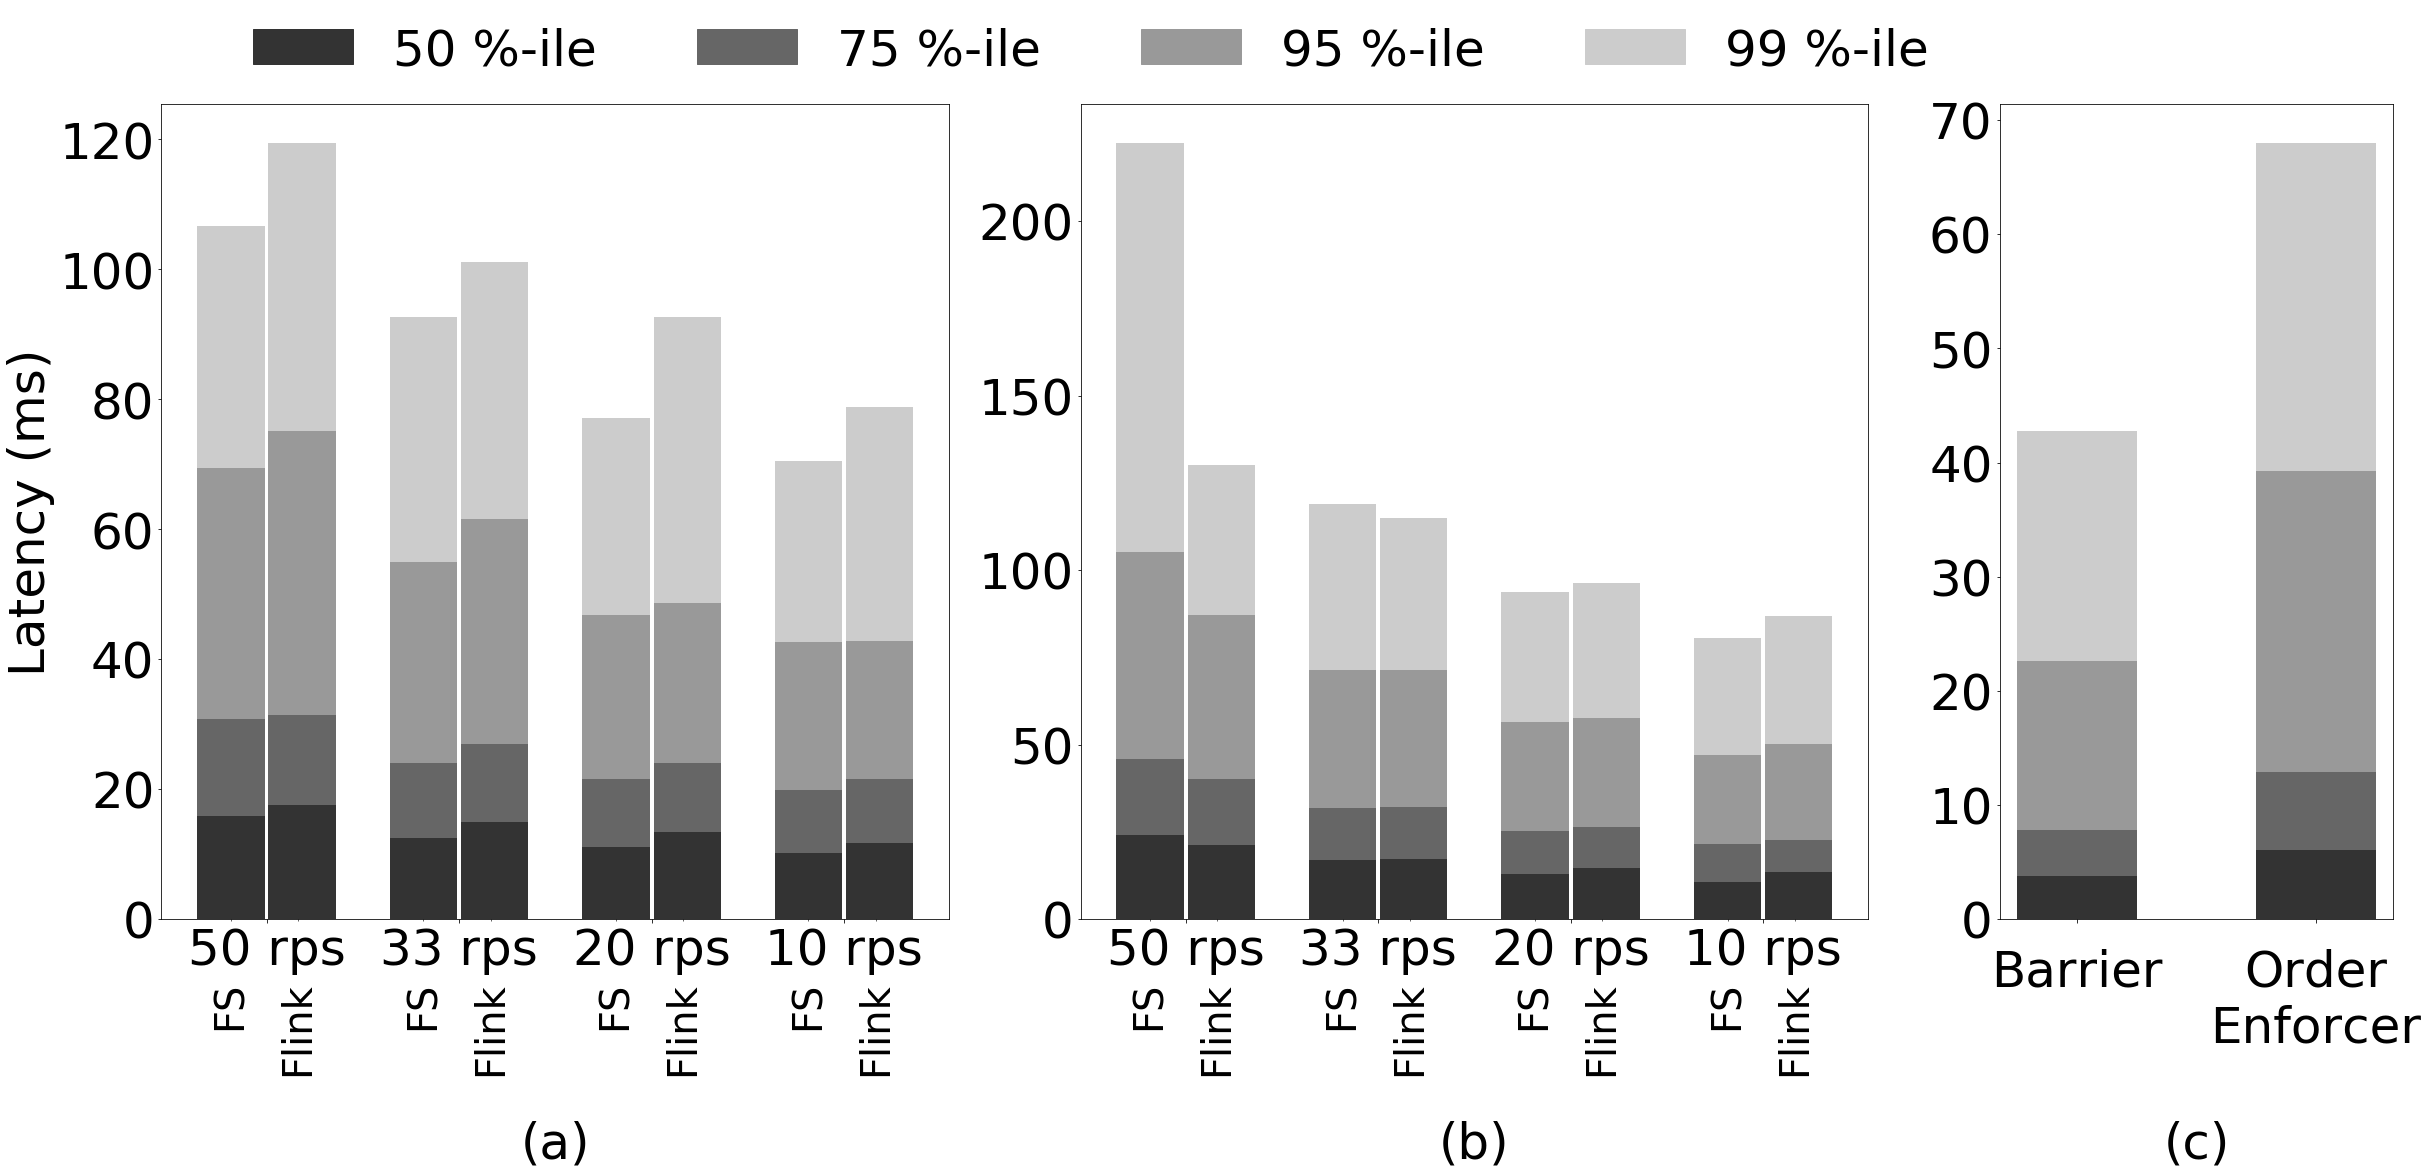

In [14]:
def do_columns_for(fs, fl, ax):
    n = 4

    ind = np.arange(1, n + 1)

    fs_q = {}
    fl_q = {}
    w = .35
    def do_plot(q, c):
        fs_q =  {rate: np.percentile(data, q) for rate, data in fs.items()}
        fl_q =  {rate: np.percentile(data, q) for rate, data in fl.items()}
        ax.bar(ind, [fs_q[20], fs_q[30],  fs_q[50], fs_q[100]], color=c, bottom = 0, width=w)
        ax.bar(ind + w + .02, [fl_q[20], fl_q[30], fl_q[50], fl_q[100]], color=c, bottom = 0, width=w)

    do_plot(99, '.8')
    do_plot(95, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')
    
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(50)
    ax.set_xticks(np.concatenate((ind, ind + w)), minor = True)
    ax.set_xticklabels(['FS'] * n + ['Flink'] * n, minor = True)
    ax.tick_params(axis='x', which='minor', pad = 60)

    rate_labels = tuple(map(lambda rate : str(1000 // rate) + ' rps', (20, 30, 50, 100)))
    ax.set_xticks(ind + w / 2 + .01)
    ax.set_xticklabels(rate_labels)

    for tick in ax.xaxis.get_minor_ticks(): tick.label.set_fontsize(40); tick.label.set_rotation(90);
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(50)
        
fig, ax = plt.subplots(1, 3, figsize=(40, 15), gridspec_kw = {'width_ratios':[2, 2, 1]})

do_columns_for(fs[10], fl[10], ax[0])
do_columns_for(fs[5], fl[5], ax[1])

ax[0].set_ylabel('Latency (ms)', fontsize=50)

#####
w = .5
ind = np.arange(1, 3)
def do_plot(q, c):
    fs_q = np.percentile(barrier, q)
    fl_q = np.percentile(enforcer, q)
    ax[2].bar(ind, [fs_q, fl_q], color=c, bottom = 0, width=w)

do_plot(99, '.8')
do_plot(95, '.6')
do_plot(75, '.4')
do_plot(50, '.2')

ax[2].set_xticks(ind)
ax[2].set_xticklabels(['Barrier', 'Order\nEnforcer'])
for tick in ax[2].xaxis.get_major_ticks(): tick.label.set_fontsize(50)
for tick in ax[2].yaxis.get_major_ticks(): tick.label.set_fontsize(50)
ax[2].tick_params(axis='x', pad = 25)
#####

patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
patch_50 = mpatches.Patch(color='.2', label='50 %-ile')

title_offset = .3
ax[0].set_title('(a)', y=-title_offset, fontsize=50) 
ax[1].set_title('(b)', y=-title_offset, fontsize=50)
ax[2].set_title('(c)', y=-title_offset, fontsize=50) 

ax[0].legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = 50, frameon=False, bbox_to_anchor=(2.3, 1.15), ncol=4)

fig.savefig("../Papers/2017/distributed_runtime_for_analytical_stream_processing/pics/comp-index-quantiles.pdf", format='pdf', bbox_inches='tight')

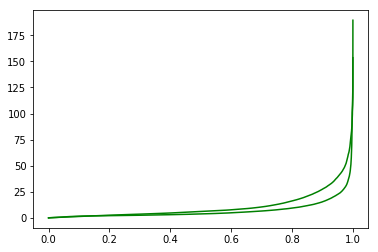

In [15]:
plt.plot(np.linspace(0, 1, np.size(barrier)), np.sort(barrier), "g", label="front - flatmap (shuffle)")
plt.plot(np.linspace(0, 1, np.size(enforcer)), np.sort(enforcer), "g", label="front - flatmap (shuffle)")

There are 0 events from: 'bench-send', to: 'front-receive-send;
There are 0 events from: 'front-receive-send', to: 'flatmap-receive;
There are 0 events from: 'fm-send', to: 'inject-in;
There are 0 events from: 'rear-in', to: 'bench-receive;


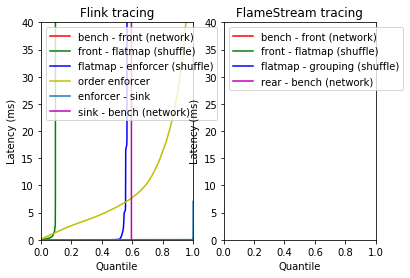

In [16]:
plt.subplot(1, 2, 1)
plt.title("Flink tracing")
plot_fl_trace(flink_trace)

plt.subplot(1, 2, 2)
plt.title("FlameStream tracing")
plot_fs_trace(trace)

plt.show()

# Latency analysis w/ consistency guarantees

NameError: name 'blink' is not defined

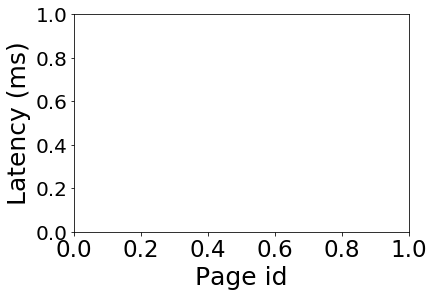

In [17]:
fig, ax = plt.subplots(frameon=False)

ax.set_ylabel('Latency (ms)', fontsize=25)
ax.set_xlabel('Page id', fontsize=25)
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(20)
for tick in ax.xaxis.get_minor_ticks(): tick.label.set_fontsize(20); tick.label.set_rotation(45);
for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(23)
    
ax.plot(blink)
plt.show()
#fig.savefig("../Papers/2018/state/pics/blink.pdf", format='pdf', bbox_inches='tight')

In [18]:
fs = {
    'at_most_once': read_data('data/141afdde/10/50' + "/AT_MOST_ONCE/50/flamestream/latency/lat.data"),
    'exactly_once': read_data('data/141afdde/10/50' + "/EXACTLY_ONCE/50/flamestream/latency/lat.data")
}
fl = {
    'at_most_once': read_data('data/141afdde/10/50' + "/AT_MOST_ONCE/50/flink/latency/lat.data"),
    'exactly_once': read_data('data/141afdde/10/50' + "/EXACTLY_ONCE/50/flink/latency/lat.data"),
    'bad_exactly_once': read_data('data/1ab106fd/10/50' + "/EXACTLY_ONCE/500/flink/latency/lat.data")
}

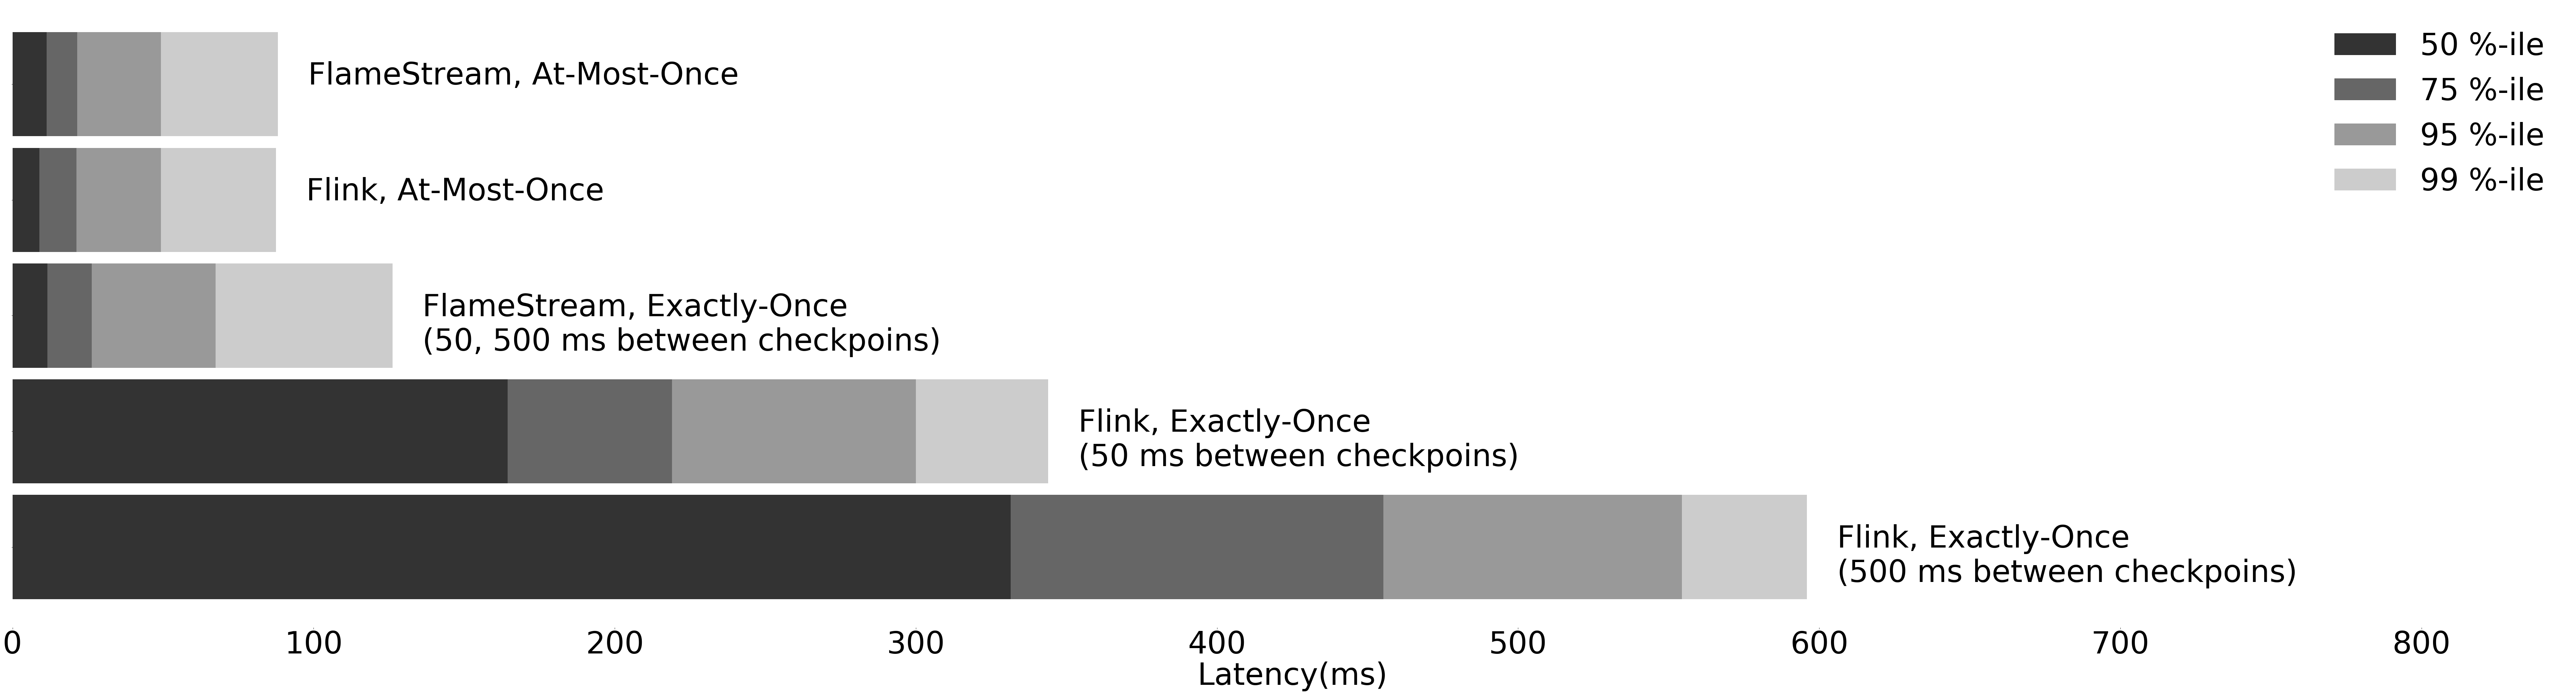

In [19]:
fig, ax = plt.subplots(figsize=(120, 30))

w = .90
ind_fs = [1, 3]
ind_fl = [2, 4, 5]
font = 80

def do_plot(q, c):
    fs_q =  {guarantee: np.percentile(data, q) for guarantee, data in fs.items()}
    fl_q =  {guarantee: np.percentile(data, q) for guarantee, data in fl.items()}
    ax.barh(ind_fs, [fs_q['at_most_once'], fs_q['exactly_once']], color=c, height=w, left=0)
    ax.barh(ind_fl, [fl_q['at_most_once'], fl_q['exactly_once'], fl_q['bad_exactly_once']], color=c, height=w, left=0)

do_plot(99, '.8')
do_plot(95, '.6')
do_plot(75, '.4')
do_plot(50, '.2')

plt.gca().invert_yaxis()

for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(font)


ax.set_yticklabels([])
plt.xlim((0, 850))

ax.set_xlabel('Latency(ms)', fontsize=font)

ax.text(np.percentile(fs['at_most_once'], 99) + 10, 1, 'FlameStream, At-Most-Once', fontsize = font)
ax.text(np.percentile(fl['at_most_once'], 99) + 10, 2, 'Flink, At-Most-Once', fontsize = font)
ax.text(np.percentile(fs['exactly_once'], 99) + 10, 3 + .3, 'FlameStream, Exactly-Once\n(50, 500 ms between checkpoins)', fontsize = font)
ax.text(np.percentile(fl['exactly_once'], 99) + 10, 4 + .3, 'Flink, Exactly-Once\n(50 ms between checkpoins)', fontsize = font)
ax.text(np.percentile(fl['bad_exactly_once'], 99) + 10, 5 + .3, 'Flink, Exactly-Once\n(500 ms between checkpoins)', fontsize = font)


patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
ax.legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = font, frameon=False, bbox_to_anchor=(1, 1), ncol=1)


for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
fig.savefig("../Papers/2018/poster-bmr/pics/comparison.pdf", format='pdf', bbox_inches='tight')

In [20]:
fs = {}
fl = {}

base = 'data/141afdde/10/50'

fs[1000] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/1000/flamestream/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/1000/flamestream/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/1000/flamestream/latency/lat.data")
}
fl[1000] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/1000/flink/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/1000/flink/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/1000/flink/latency/lat.data")
}

fs[50] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/50/flamestream/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/50/flamestream/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/50/flamestream/latency/lat.data")
}
fl[50] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/50/flink/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/50/flink/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/50/flink/latency/lat.data")
}

base = 'data/1ab106fd/10/50'

fs[500] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/500/flamestream/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/500/flamestream/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/500/flamestream/latency/lat.data")
}
fl[500] = {
    'at_most_once': read_data(base + "/AT_MOST_ONCE/500/flink/latency/lat.data"),
    'at_least_once': read_data(base + "/AT_LEAST_ONCE/500/flink/latency/lat.data"),
    'exactly_once': read_data(base + "/EXACTLY_ONCE/500/flink/latency/lat.data")
}

fs[50]['at_most_once'] = fs[1000]['at_most_once']

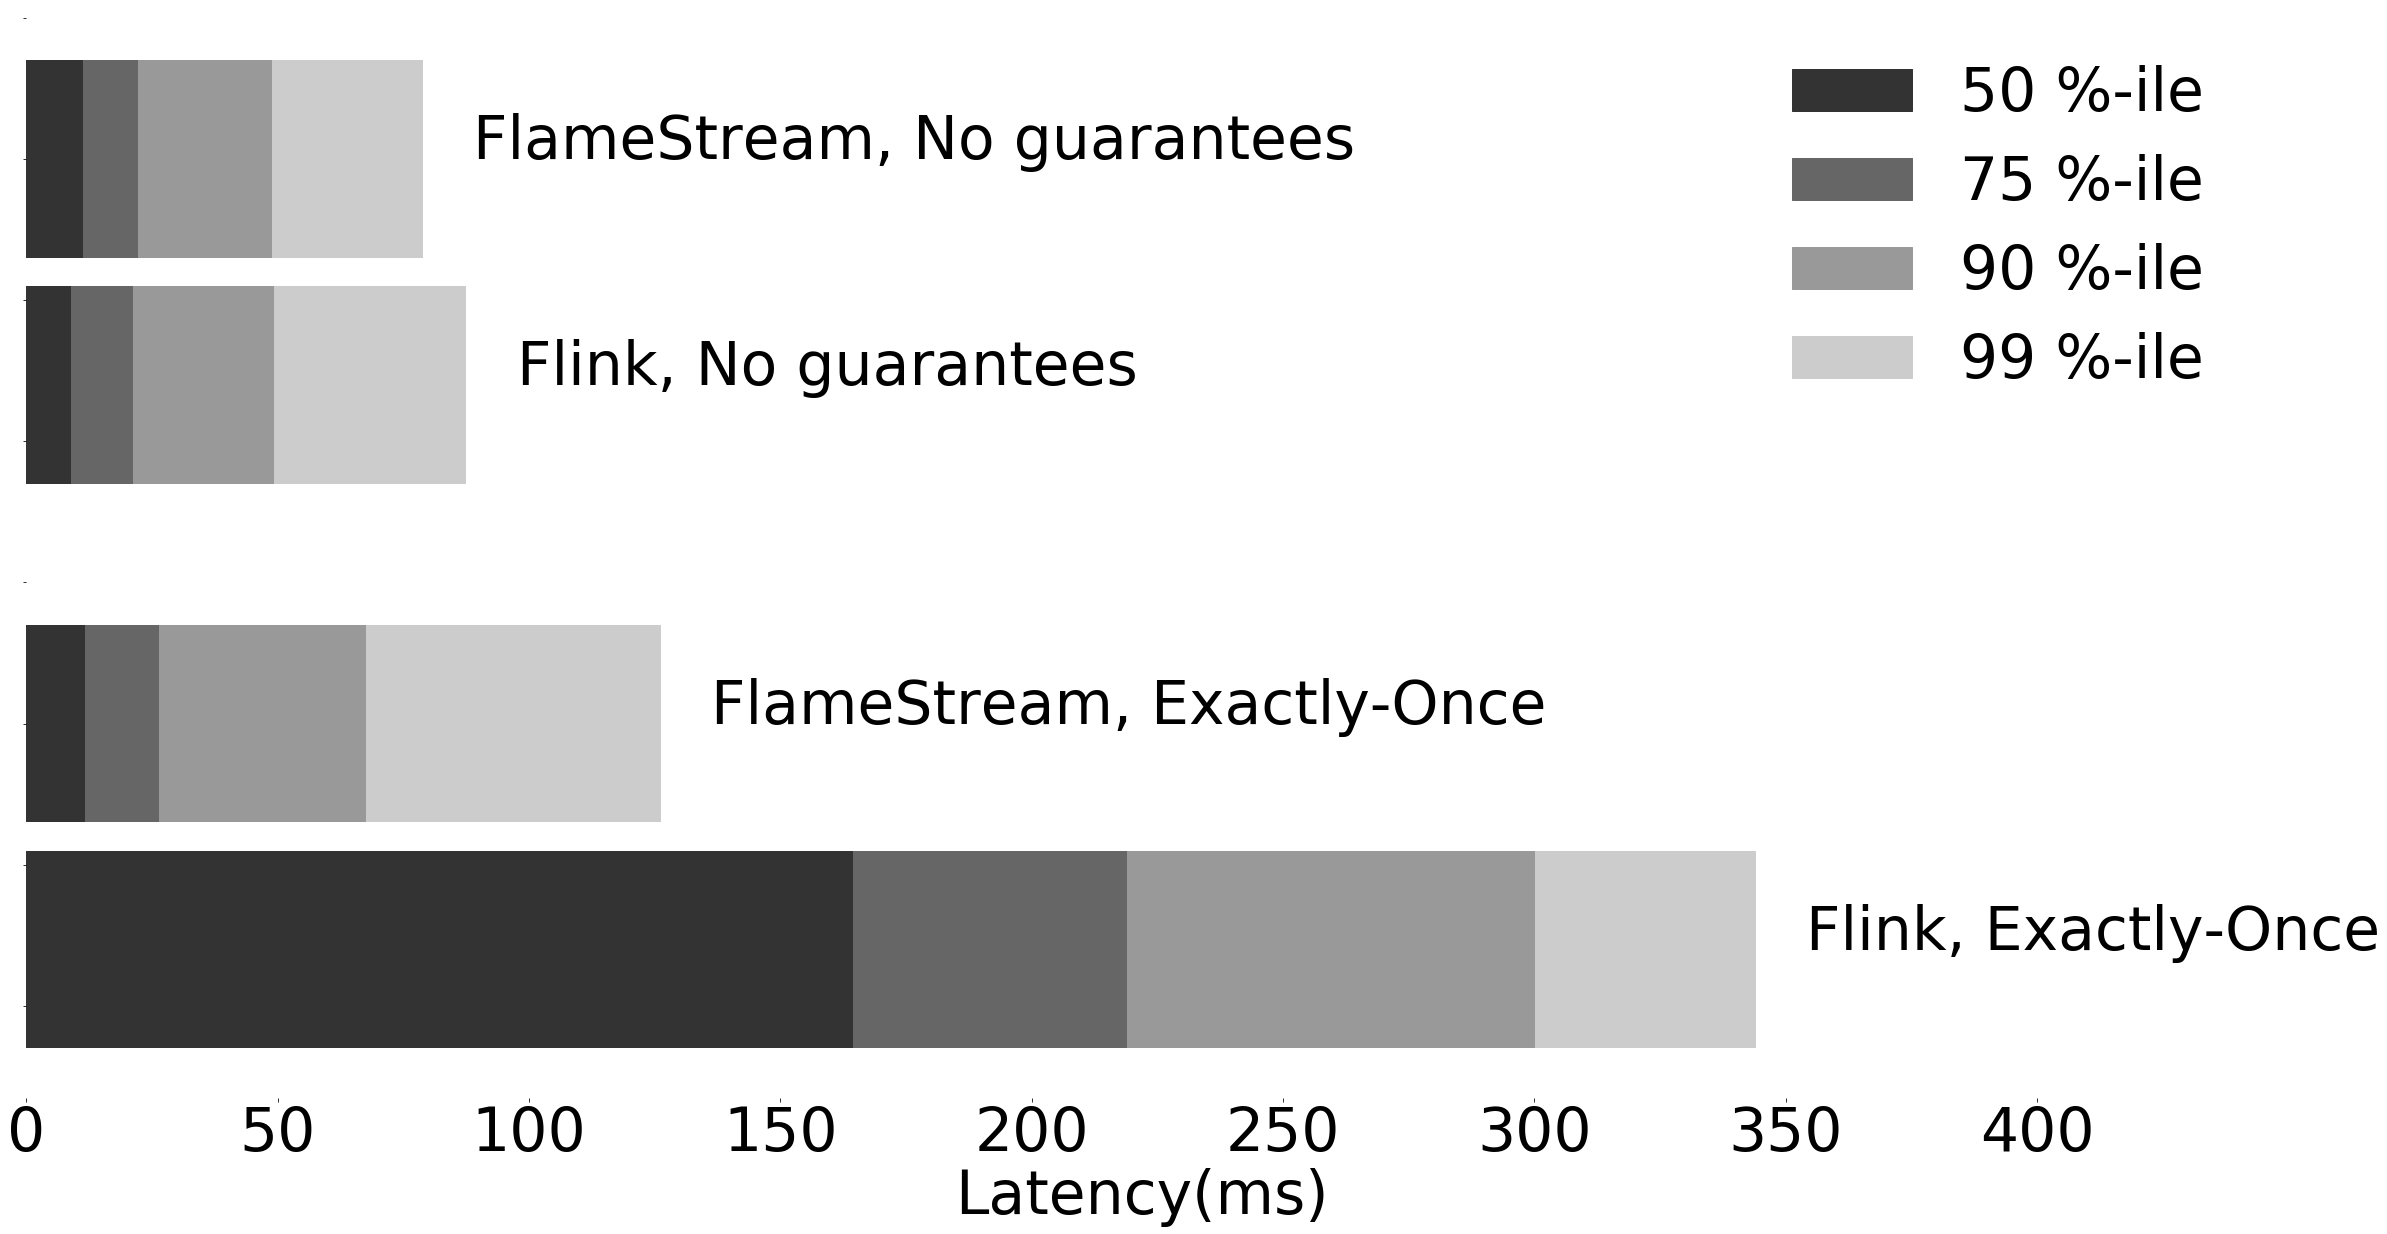

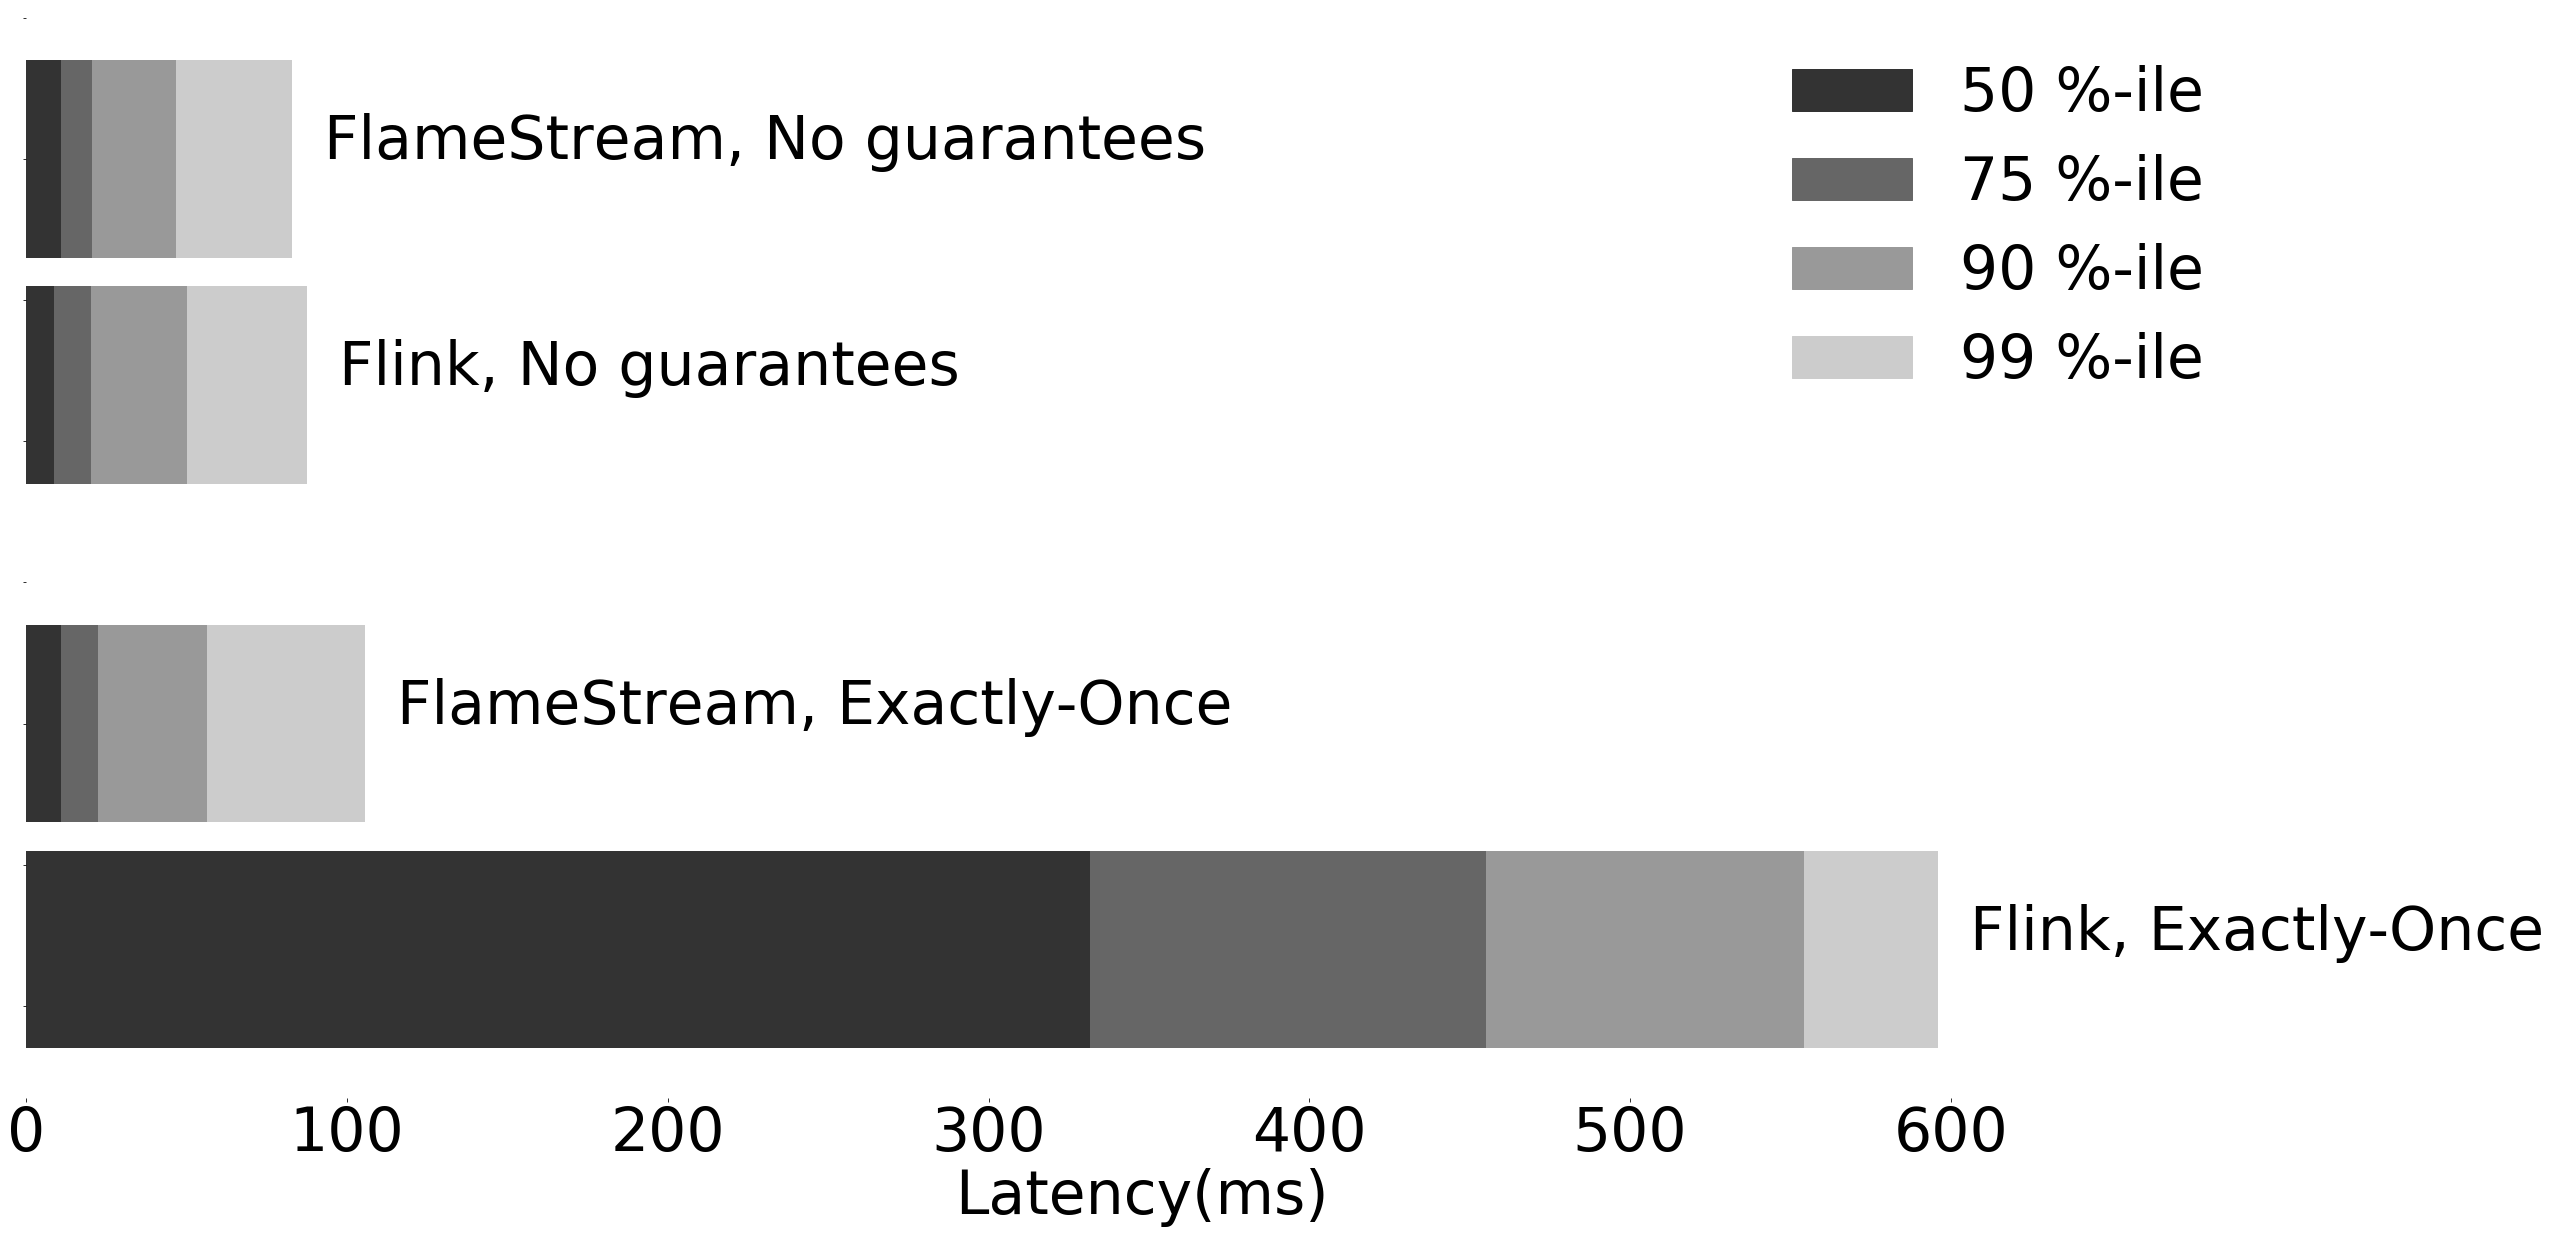

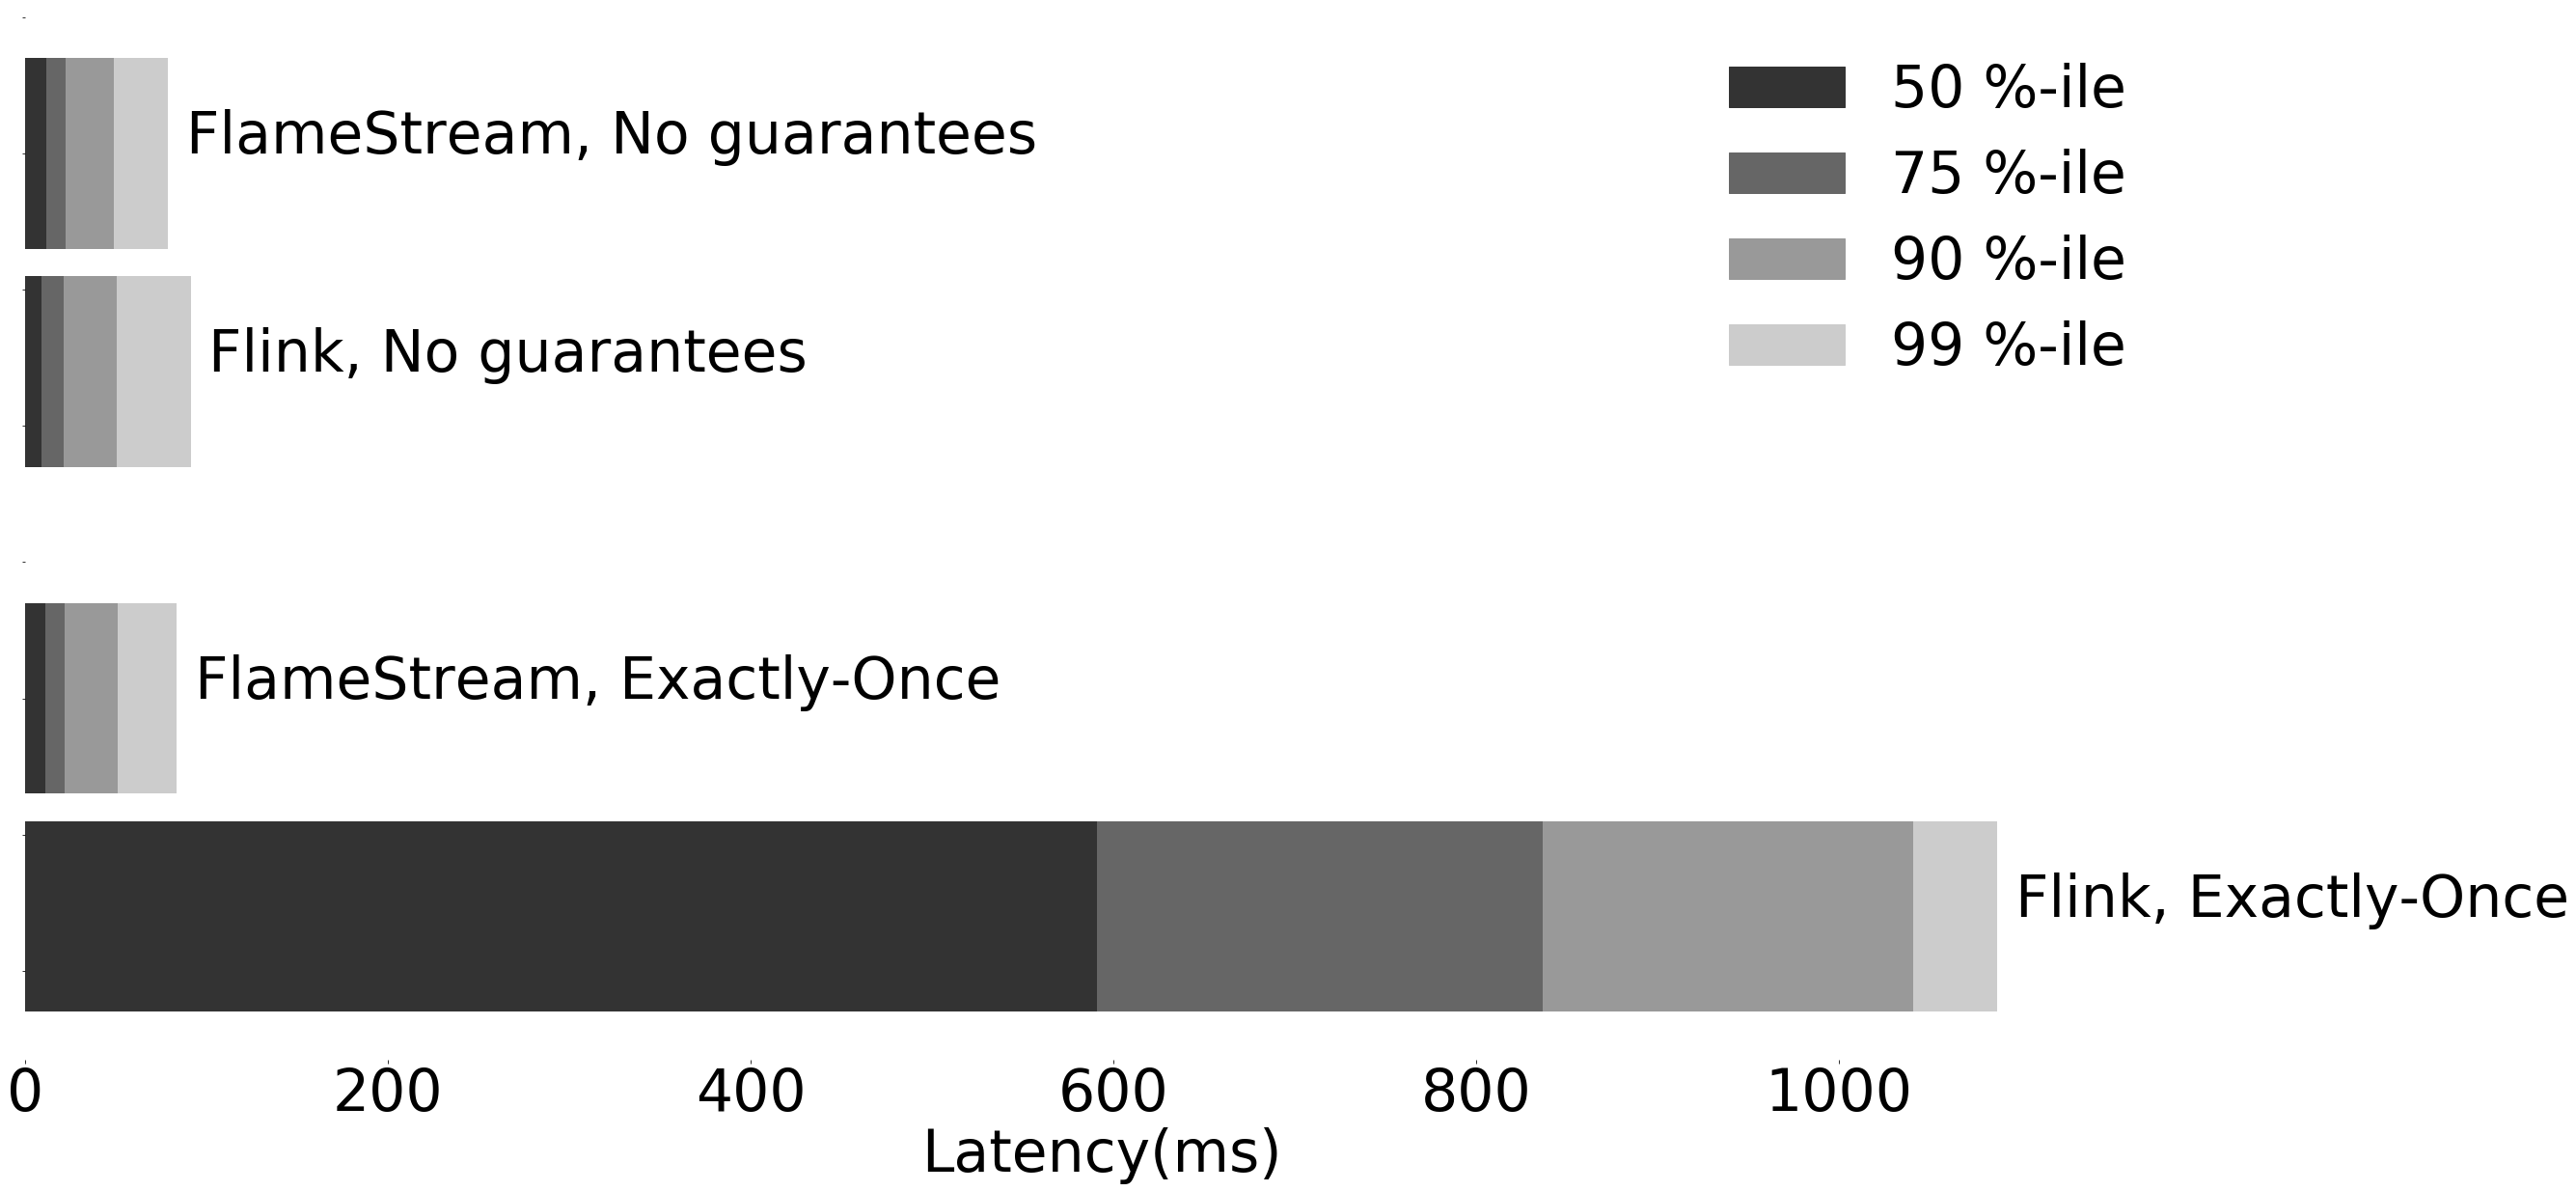

In [25]:
def plot_for_delay(delay):
    fig, ax = plt.subplots(figsize=(40, 20))
    w = .70
    ind_fs = [1, 3.0]
    ind_fl = [1.8, 3.8]

    def do_plot(q, c):
        fs_q =  {guarantee: np.percentile(data, q) for guarantee, data in fs[delay].items()}
        fl_q =  {guarantee: np.percentile(data, q) for guarantee, data in fl[delay].items()}
        ax.barh(ind_fs, [fs_q['at_most_once'], fs_q['exactly_once']], color=c, height=w, left=0)
        ax.barh(ind_fl, [fl_q['at_most_once'], fl_q['exactly_once']], color=c, height=w, left=0)

    do_plot(99, '.8')
    do_plot(95, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')

    plt.gca().invert_yaxis()

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(60)

    ax.set_yticklabels([])
    plt.xlim((0, np.percentile(fl[delay]['exactly_once'], 99) + 100))

    ax.set_xlabel('Latency(ms)', fontsize=60)

    ax.text(np.percentile(fs[delay]['at_most_once'], 99) + 10, 1, 'FlameStream, No guarantees', fontsize = 60)
    ax.text(np.percentile(fl[delay]['at_most_once'], 99) + 10, 1.8, 'Flink, No guarantees', fontsize = 60)
#     ax.text(np.percentile(fs[delay]['at_least_once'], 99) + 10, 3.5, 'FlameStream, At-Least-Once', fontsize = 60)
#     ax.text(np.percentile(fl[delay]['at_least_once'], 99) + 10, 4.5, 'Flink, At-Least-Once', fontsize = 60)
    ax.text(np.percentile(fs[delay]['exactly_once'], 99) + 10, 3, 'FlameStream, Exactly-Once', fontsize = 60)
    ax.text(np.percentile(fl[delay]['exactly_once'], 99) + 10, 3.8, 'Flink, Exactly-Once', fontsize = 60)


    patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
    patch_95 = mpatches.Patch(color='.6', label='95 %-ile')
    patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
    patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
    ax.legend(handles=[patch_99, patch_95, patch_75, patch_50][::-1], fontsize = 60, frameon=False, bbox_to_anchor=(1, 1), ncol=1)


    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    fig.savefig("comparison" + str(delay) + ".pdf", format='pdf', bbox_inches='tight')
    
plot_for_delay(50)
plot_for_delay(500)
plot_for_delay(1000)

# Failure example

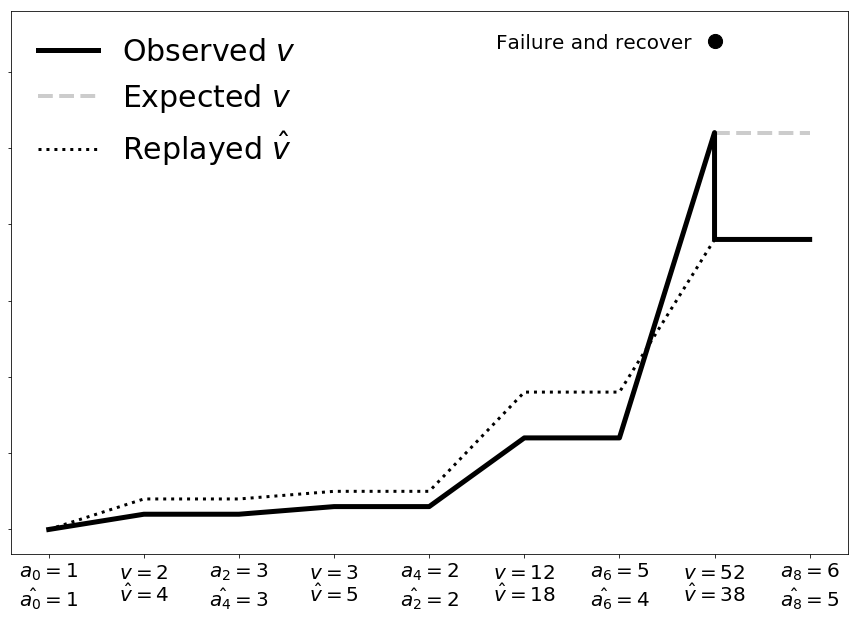

In [22]:
tau = [0, 1, 2, 3, 4, 5, 6, 7, 8]
tau2 = [0, 1, 4, 3, 2, 5, 6, 7, 8]
a = [4, 1, 3, 2, 5, 6, 6, 7, 8]
alt_a = [0, 1, 3, 2, 4, 5, 6, 7, 8]
expected_state = [0, 2, 2, 3, 3, 12, 12, 52, 52]
alternative_state = [0, 4, 4, 5, 5, 18, 18, 38, 38]
observed_state = [0, 4, 4, 5, 5, 18, 18, 38, 38]


x_labels = []
for t in tau:
    
    if t % 2 == 0:
        obj = 'a'
        value = a[int((t / 2) + 1)]
        alt_value = alt_a[int((t / 2) + 1)]
        t2 = tau2[t]
        t1 = t
    else:
        obj = 'v'
        value = expected_state[t]
        alt_value = alternative_state[t]
        t2 = ''
        t1 = ''
        
    label = '${obj}_{{{time1}}}={value}$\n$\hat{{{obj}_{{{time2}}}}}={alt_value}$'.format(time1=t1, time2=t2, obj=obj, state=observed_state[t], value=value, alt_value=alt_value)
    x_labels.append(label)
switch = 8
real_tau = tau[:switch] + [switch - 1] + tau[switch:]
real_path = expected_state[:switch] + [alternative_state[switch]] + alternative_state[switch:]
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(real_tau, real_path, 'k', linewidth=5, label='Observed $v$')
ax.plot(tau[switch - 1:], expected_state[switch - 1:], '--', color="black", alpha=0.2, linewidth=4, label='Expected $v$')
ax.plot(tau[:switch], alternative_state[:switch], ':k', linewidth=3, label='Replayed $\hat{v}$')
#ax.axvline(x=2, linestyle='--', color='g', linewidth=3, label='Replay start')
#ax.axvline(x=switch - 1, linestyle='--', color='r', linewidth=3, label='Failure and recover')
ax.legend(fontsize=30, frameon=False, ncol=1)
ax.set_yticklabels([])
ax.set_xticks(tau)
ax.set_xticklabels(x_labels, fontsize=20)

# ax.text(1, 4, 'Replay start', fontsize=20)
# ax.scatter([2], [1], s=200, color='k')

ax.text(4.7, 63, 'Failure and recover', fontsize=20)
ax.scatter([7], [64], s=200, color='k')
fig.savefig("failure.pdf", format='pdf', bbox_inches='tight')
